# Goal of this notebook

The goal of this notebook is to use random forest as a exploratory data analysis tool. We want to find out which features are important, which features are duplicates, and see how train and validation datasets are different.

# Import libraries and get data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Let's take a look at all the datasets including the original dataset. We can take a look at data, quantile statistics, data types and missing values. By setting `low_memory=False`, we force `pandas` to read all the rows before deciding on the data type.

In [3]:
train = pd.read_csv("train.csv", low_memory=False).drop('id', axis=1)
test = pd.read_csv("test.csv", low_memory=False).drop('id', axis=1)
original = pd.read_csv("credit_risk_dataset.csv", low_memory=False)

In [4]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,...,0.17,N,14,0
1,22,56000,OWN,6.0,...,0.07,N,2,0
2,29,28800,OWN,8.0,...,0.21,N,10,0
3,30,70000,RENT,14.0,...,0.17,N,5,0
4,22,60000,RENT,2.0,...,0.10,N,3,0


In [5]:
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [7]:
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,23,69000,RENT,3.0,...,15.76,0.36,N,2
1,26,96000,MORTGAGE,6.0,...,12.68,0.10,Y,4
2,26,30000,RENT,5.0,...,17.19,0.13,Y,2
3,33,50000,RENT,4.0,...,8.90,0.14,N,7
4,26,102000,MORTGAGE,8.0,...,16.32,0.15,Y,4


In [8]:
test.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.3+ MB


In [10]:
original.head()

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,...,1,0.59,Y,3
1,21,9600,OWN,5.0,...,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,...,1,0.57,N,3
3,23,65500,RENT,4.0,...,1,0.53,N,2
4,24,54400,RENT,8.0,...,1,0.55,Y,4


In [11]:
original.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [12]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


The `original` dataset has some missing values for `person_emp_length` and `loan_int_rate`. 

# Cleaning data

Here are the columns explained by [@rv1922](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536984).

- id: Unique identifier for each record.
- person_age: Age of the individual, categorized into ranges.
- person_income: Income of the individual, categorized into income ranges.
- person_home_ownership: Homeownership status, which includes categories like 'RENT', 'MORTGAGE', etc.
- person_emp_length: Employment length of the individual, categorized into ranges based on years.
- loan_intent: The purpose of the loan, with categories such as 'EDUCATION', 'MEDICAL', etc.
- loan_grade: The credit grade of the loan, such as 'A', 'B', etc.
- loan_amnt: Loan amount, categorized into ranges.
- loan_int_rate: Loan interest rate, categorized into percentage ranges.
- loan_percent_income: Percentage of the individual’s income that the loan represents, categorized into - ranges.
- cb_person_default_on_file: Whether the person has a history of loan default, with values 'true' or 'false'.
- cb_person_cred_hist_length: Length of the individual’s credit history, categorized into ranges.
- loan_status: with values representing whether the loan status approval (0 is approval)

In [13]:
dep_var = 'loan_status'

## Fill missing values

For the `original` dataset, we will use median values to fill in the gap.

In [14]:
original['person_emp_length'] = original['person_emp_length'].fillna(original['person_emp_length'].median())
original['loan_int_rate'] = original['loan_int_rate'].fillna(original['loan_int_rate'].median())

In [15]:
original.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

We can concatenate train and original for bigger a trainining data.

In [16]:
train = pd.concat([train, original])
train.shape

(91226, 12)

## Checking for duplicate data

There are duplicate data in original dataset, so we drop them.

In [17]:
original.duplicated().sum()

165

In [18]:
train.duplicated().sum()

166

In [19]:
train.drop_duplicates(inplace=True)

In [20]:
train.duplicated().sum()

0

## Handling ordinal columns

In [21]:
train = pd.concat([train, original])
df = pd.concat([train, test])

Ordinal columns are columns containing strings or similar, but where those strings have ordering. Looking at the columns, we can see `loan_grade` may have a natural ordering.

In [22]:
df['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

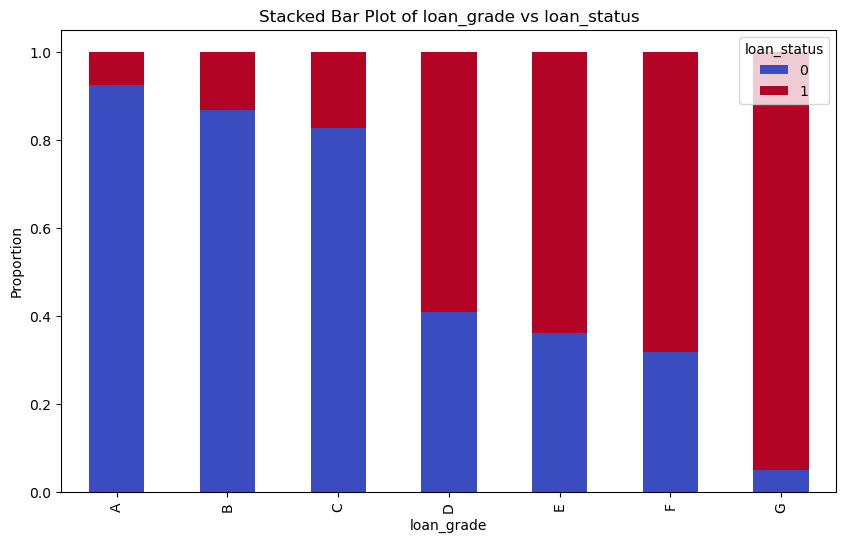

In [23]:
def stacked_bar_plot(df, feature, target=dep_var):
    crosstab = pd.crosstab(df[feature], df[target], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')
    plt.title(f'Stacked Bar Plot of {feature} vs {target}')
    plt.ylabel('Proportion')
    plt.show()

stacked_bar_plot(train, 'loan_grade')

The plot shows A is the best status and G is the worst, where 0 is approval and 1 is denied. Let's make `loan_grade` ordinal. Seems like we can seperate it into {A, B, C}, {D, E, F}, and {G}. We can try that later.

In [24]:
df['loan_grade'] = df['loan_grade'].astype('category')
df['loan_grade'] = df['loan_grade'].cat.as_ordered()

In [25]:
df['loan_grade']

0        B
1        C
2        A
3        B
4        A
        ..
39093    B
39094    A
39095    A
39096    D
39097    B
Name: loan_grade, Length: 162739, dtype: category
Categories (7, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G']

## Category vs. continuous

In [26]:
procs = [Categorify, FillMissing]

In [27]:
cont_cols, cat_cols = cont_cat_split(df, dep_var=dep_var)
cont_cols, cat_cols

(['person_age',
  'person_income',
  'person_emp_length',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_cred_hist_length'],
 ['person_home_ownership',
  'loan_intent',
  'loan_grade',
  'cb_person_default_on_file'])

In [28]:
def split_idxs(df, seed = 42, test_ratio = 0.2):
    np.random.seed(seed)
    n_idxs = len(df)
    shuffled_idxs = np.random.permutation(n_idxs)
    split_idxs = int(n_idxs * test_ratio)
    tst_idxs = shuffled_idxs[:split_idxs]
    trn_idxs = shuffled_idxs[split_idxs:]
    return (list(trn_idxs), list(tst_idxs))

In [29]:
splits = split_idxs(train)

In [30]:
to = TabularPandas(train, procs, cat_cols, cont_cols, y_names=dep_var, splits=splits)

In [31]:
len(to.train),len(to.valid)

(98913, 24728)

In [32]:
to.show(3)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
15233,OWN,EDUCATION,B,N,23,24000,5.0,7000,11.86,0.29,4,0
22395,MORTGAGE,HOMEIMPROVEMENT,C,N,34,55000,6.0,2500,13.49,0.05,7,0
19264,RENT,EDUCATION,C,Y,27,25800,11.0,2500,10.99,0.10,5,0


In [33]:
to.items.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,...,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
15233,23,24000,3,5.0,...,0.29,1,4,0
22395,34,55000,1,6.0,...,0.05,1,7,0
19264,27,25800,4,11.0,...,0.10,2,5,0


In [34]:
to.classes['loan_grade']

['#na#', 'A', 'B', 'C', 'D', 'E', 'F', 'G']

In [35]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [36]:
xs

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,...,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
15233,3,2,2,1,...,7000,11.86,0.29,4
22395,1,3,3,1,...,2500,13.49,0.05,7
19264,4,2,3,2,...,2500,10.99,0.10,5
28758,1,4,6,1,...,10000,18.09,0.14,9
31524,1,6,4,1,...,6000,14.11,0.06,16
...,...,...,...,...,...,...,...,...,...
28819,1,6,1,1,...,20000,10.99,0.11,6
12634,4,1,2,1,...,3000,10.25,0.11,4
860,1,5,1,1,...,3350,5.42,0.03,6
15795,1,2,3,2,...,3000,13.23,0.03,9


In [37]:
y

15233    0
22395    0
19264    0
28758    1
31524    0
        ..
28819    0
12634    0
860      0
15795    0
30898    0
Name: loan_status, Length: 98913, dtype: int8

## Random Forest

In [38]:
def rf(xs, y, n_estimators=40, max_samples=20_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [39]:
m = rf(xs, y, max_samples=None, n_estimators=80)

In [40]:
def m_roc(m, xs, y): return roc_auc_score(y, m.predict(xs))

In [41]:
m.predict(xs)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [42]:
np.stack([t.predict(xs) for t in m.estimators_]).mean(0)

array([0.025 , 0.05  , 0.05  , ..., 0.    , 0.0125, 0.    ])

In [43]:
m_roc(m, xs, y), m_roc(m, valid_xs, valid_y)

(0.8938254132303877, 0.8614277826793348)

In [44]:
# Train
roc_auc_score(y, np.stack([t.predict(xs) for t in m.estimators_]).mean(0))

0.9942494626595837

In [45]:
# Validation
roc_auc_score(valid_y, np.stack([t.predict(valid_xs) for t in m.estimators_]).mean(axis=0))

0.966704409194445

In [46]:
to2 = TabularPandas(test, procs, cat_cols, cont_cols)
len(to2.train),len(to2.valid)

(39098, 0)

In [47]:
test_xs = to2.train.xs

In [48]:
preds = np.stack([t.predict(test_xs) for t in m.estimators_]).mean(0)
preds

array([1.    , 0.0125, 0.55  , ..., 0.    , 0.5125, 0.975 ])

In [49]:
## create submission
test = pd.read_csv("test.csv", low_memory=False)
submission = test[['id']].copy()
submission['loan_status'] = np.stack([t.predict(test_xs) for t in m.estimators_]).mean(0)

submission.to_csv('submission.csv', index=False)
submission

,id,loan_status
0,58645,1.0000
1,58646,0.0125
2,58647,0.5500
3,58648,0.0000
4,58649,0.0500
...,...,...
39093,97738,0.0375
39094,97739,0.0000
39095,97740,0.0000
39096,97741,0.5125
